In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2


2026-02-06 15:54:45.417119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('coffee_beans.csv')
X = df["filepaths"]
y = df["class index"]


In [3]:
def load_images(x):
    images = []
    for path in x:
        img = cv2.imread(path)
        if img is None:
            print(f"Could not read image: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = img / 255.0  # normalize
    
        images.append(img)
    
    images = np.array(images, dtype=np.float32)
    return images



Split dataset into training, validation and test set. This split will be used to choose the best neural network architecture for the final model.

In [4]:
from sklearn.model_selection import train_test_split

X_train, x_, y_train, y_ = train_test_split(X , y, test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(x_ , y_, test_size=0.20, random_state=1)

del x_, y_

Load the images defined in the $x$ sets.

In [5]:
X_train = load_images(X_train)
X_cv = load_images(X_cv)
X_test = load_images(X_test)

Implementing data augmentation to address overfitting due to the limited size of the dataset

In [7]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input


In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(factor=0.1),
])   

In [9]:
tf.keras.utils.set_random_seed(42) # seed for reproducibility

# Pre Trained CNN
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # freeze pretrained weights

l = 1e-1
model_1 = models.Sequential([
    data_augmentation,
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(4, activation='linear', kernel_regularizer=regularizers.l2(l))
])

nn_models = [model_1]

In [22]:
from sklearn.metrics import log_loss

nn_train_cross_entropy = []
nn_cv_cross_entropy = []

for model in nn_models:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # gradient descent optimatiation
        loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'], # ??? have to research
    )
    print(f"Training {model.name}...")
    
    model.fit(X_train, y_train, epochs=10)
    print("Done\n")

    # Instantiate loss function
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    # Record the training Log Losses
    yhat = model.predict(X_train)
    # pred_class = np.argmax(yhat, axis=1)[0]
    train_cross_entropy = loss_fn(y_train, yhat).numpy()
    nn_train_cross_entropy.append(train_cross_entropy)

    # Record the cross validation Log Losses
    yhat = model.predict(X_cv)
    # pred_class = np.argmax(yhat, axis=1)[0]
    cv_cross_entropy = loss_fn(y_cv, yhat).numpy()
    nn_cv_cross_entropy.append(cv_cross_entropy)

Training sequential_1...
Epoch 1/10


2026-02-06 16:20:35.630670: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 578027520 exceeds 10% of free system memory.


30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 812ms/step - accuracy: 0.7531 - loss: 1.1521
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7719 - loss: 0.8810
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 969ms/step - accuracy: 0.7719 - loss: 0.8063
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 890ms/step - accuracy: 0.7979 - loss: 0.7542
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7771 - loss: 0.7774
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 897ms/step - accuracy: 0.7750 - loss: 0.7728
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 949ms/step - accuracy: 0.7771 - loss: 0.7216
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 903ms/step - accuracy: 0.7885 - loss: 0.7293
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 885ms/step - accuracy: 0.7833 - loss: 0.7515
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 868ms/step - accuracy: 0.7906 - loss: 0.7016
Done



2026-02-06 16:25:40.633841: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 578027520 exceeds 10% of free system memory.


30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 871ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 740ms/step


Because softmax is integrated into the output layer the output s a vector of probabilities.

In [23]:
for _, model in enumerate(nn_models):
    print(
        f"{model.name} Performance Summary\n"
        f"-----------------------------\n"
        f"Training Cross-Entropy Loss : {nn_train_cross_entropy[_]:.4f}\n"
        f"CV Cross-Entropy Loss       : {nn_cv_cross_entropy[_]:.4f}\n"
    )


sequential_1 Performance Summary
-----------------------------
Training Cross-Entropy Loss : 0.7042
CV Cross-Entropy Loss       : 0.7314



Plot $J_{\text{cv}}$ and $J_{\text{train}}$

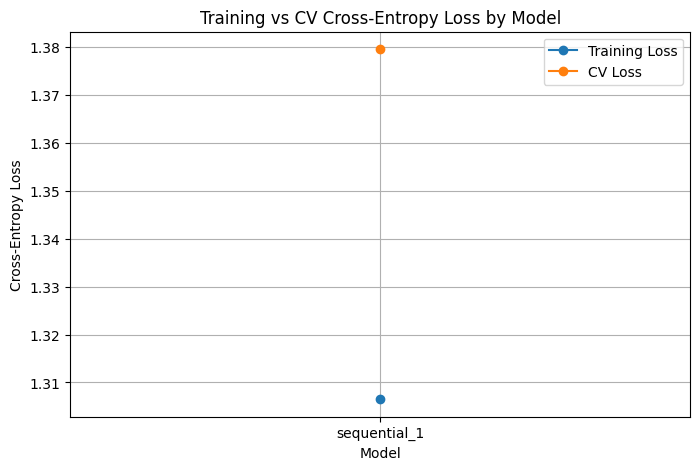

In [13]:
import matplotlib.pyplot as plt

# Extract model names
model_names = [model.name for model in nn_models]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(model_names, nn_train_cross_entropy, marker='o', label='Training Loss')
plt.plot(model_names, nn_cv_cross_entropy, marker='o', label='CV Loss')

# Labels and title
plt.xlabel('Model')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs CV Cross-Entropy Loss by Model')
plt.legend()
plt.grid(True)

plt.show()


Make predictions

In [14]:
nn_models

[<Sequential name=sequential_1, built=True>]

In [15]:
class_names = {
    0: "Dark",
    1: "Green",
    2: "Light",
    3: "Medium"
}


In [34]:
IMG_SIZE = 224

img = cv2.imread("test/Green/green (25).png")
# img = cv2.imread("../../medium-roast-224-224.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img / 255.0

img = np.expand_dims(img, axis=0)  # shape (1, 224, 224, 3)

pred = model.predict(img)
pred_class = np.argmax(pred, axis=1)[0]

print("Predicted:", class_names[pred_class])
print("Class probabilities (Dark, Green, Light, Medium):", pred[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted: Green
Class probabilities (Dark, Green, Light, Medium): [-3.024387   2.2470708  2.2400405 -1.472733 ]


Save the model

In [35]:
model.save("coffee_roast_model.keras")